# EDA

In [75]:
# ! pip install torch_geometric

In [76]:
# # Print node features matrix
# print("Node features matrix (x):")
# print(data.x)
# print("Shape of node features matrix:", data.x.size())

# # Print edge index matrix
# print("\nEdge index matrix (edge_index):")
# print(data.edge_index)
# print("Shape of edge index matrix:", data.edge_index.size())

# # Check if the graph is directed
# print("\nIs the graph directed?:", data.is_directed())

# # Additional graph information (if available)
# if data.y is not None:
#     print("\nLabels (y):")
#     print(data.y)
#     print("Shape of labels:", data.y.size())

# if hasattr(data, 'train_mask'):
#     print("\nTraining mask (if available):")
#     print(data.train_mask)

# if hasattr(data, 'test_mask'):
#     print("\nTesting mask (if available):")
#     print(data.test_mask)

# if hasattr(data, 'val_mask'):
#     print("\nValidation mask (if available):")
#     print(data.val_mask)

# # Print number of nodes and edges
# print("\nNumber of nodes:", data.num_nodes)
# print("Number of edges:", data.num_edges)

# # Print additional statistics if needed
# # Degree distribution, etc.


In [77]:
import pandas as pd
import re
import torch
from torch_geometric.data import Data
from transformers import BertTokenizer, BertModel
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader

# Load the dataset
file_path = "modified_core_defect.csv"
firefox_issues_df = pd.read_csv(file_path)

# Clean and preprocess data
firefox_issues_df.dropna(subset=['severity', 'product', 'component', 'priority', 'status'], inplace=True)
firefox_issues_df['summary'] = firefox_issues_df['summary'].str.lower()
firefox_issues_df['summary'] = firefox_issues_df['summary'].apply(lambda x: re.sub(r'[^a-z0-9\s]', '', x))

firefox_issues_df.replace('--', pd.NA, inplace=True)
firefox_issues_df.dropna(subset=['severity', 'priority'], inplace=True)

# Encode 'Product', 'Component', and 'Status' using label encoding
product_encoder = LabelEncoder()
component_encoder = LabelEncoder()
status_encoder = LabelEncoder()
firefox_issues_df['product_encoded'] = product_encoder.fit_transform(firefox_issues_df['product'])
firefox_issues_df['component_encoded'] = component_encoder.fit_transform(firefox_issues_df['component'])
firefox_issues_df['status_encoded'] = status_encoder.fit_transform(firefox_issues_df['status'])

# Initialize BERT tokenizer and model with a specified cache directory
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='cache')
model = BertModel.from_pretrained('bert-base-uncased', cache_dir='cache')

# Set the device to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function for batch processing of summaries to obtain BERT embeddings
def batch_encode_summaries(summaries, tokenizer, model, batch_size=16):
    dataloader = DataLoader(summaries, batch_size=batch_size, shuffle=False)
    text_features_list = []

    for batch_summaries in dataloader:
        inputs = tokenizer(batch_summaries, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_text_features = outputs.last_hidden_state.mean(dim=1)
        text_features_list.append(batch_text_features.cpu())  # Move to CPU to avoid GPU memory overload

    return torch.cat(text_features_list, dim=0)

# Encode summaries in batches to get text features
text_features = batch_encode_summaries(firefox_issues_df['summary'].tolist(), tokenizer, model, batch_size=16)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns for scaling
features_to_scale = firefox_issues_df[['product_encoded', 'component_encoded', 'status_encoded']]

# Fit the scaler to the features and transform them to a 0-1 range
scaled_features = scaler.fit_transform(features_to_scale)

# Update the dataframe with the scaled features
firefox_issues_df[['product_encoded', 'component_encoded', 'status_encoded']] = scaled_features

# Calculate 'count of blocks' and 'count of depends_on'
firefox_issues_df['blocks_count'] = firefox_issues_df['blocks'].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)
firefox_issues_df['depends_on_count'] = firefox_issues_df['depends_on'].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)

# Scale the counts
count_features = firefox_issues_df[['blocks_count', 'depends_on_count']]
scaled_count_features = scaler.fit_transform(count_features)
firefox_issues_df[['blocks_count', 'depends_on_count']] = scaled_count_features

# Prepare the features tensor including the new count features
features_tensor = torch.tensor(firefox_issues_df[['product_encoded', 'component_encoded', 'status_encoded', 'blocks_count', 'depends_on_count']].values, dtype=torch.float)

# Concatenate the BERT embeddings with the scaled features
features = torch.cat((text_features, features_tensor), dim=1)

# Prepare edge index and map issue IDs to node indices
node_id_mapping = {node_id: idx for idx, node_id in enumerate(firefox_issues_df['id'])}
edge_index = []

for _, row in firefox_issues_df.iterrows():
    node_idx = node_id_mapping[row['id']]
    blocked_ids = ast.literal_eval(row['blocks']) if pd.notnull(row['blocks']) else []
    depends_ids = ast.literal_eval(row['depends_on']) if pd.notnull(row['depends_on']) else []

    for blocked_id in blocked_ids:
        if blocked_id in node_id_mapping:
            edge_index.append([node_idx, node_id_mapping[blocked_id]])

    for depend_id in depends_ids:
        if depend_id in node_id_mapping:
            edge_index.append([ node_idx,node_id_mapping[depend_id]])

edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Convert the 'priority' and 'severity' columns to tensors
priority_labels = torch.tensor(firefox_issues_df['priority'].values, dtype=torch.long)
severity_labels = torch.tensor(firefox_issues_df['severity'].values, dtype=torch.long)

# Create PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_index_tensor, y_priority=priority_labels, y_severity=severity_labels)

# Save the Data object
data_save_path = 'firefox_issues_data.pt'
torch.save(data, data_save_path)


In [78]:
# Assuming you have defined num_classes_priority and num_classes_severity
num_classes_priority = 4  # Example: 6 priority classes
num_classes_severity = 3  # Example: 6 severity classes

# Check the range for priority labels
priority_label_min = data.y_priority.min().item()
priority_label_max = data.y_priority.max().item()

if priority_label_min < 0 or priority_label_max >= num_classes_priority:
    print(f"Priority labels out of expected range [0, {num_classes_priority-1}]: Min = {priority_label_min}, Max = {priority_label_max}")
else:
    print(f"Priority labels within expected range [0, {num_classes_priority-1}].")

# Check the range for severity labels
severity_label_min = data.y_severity.min().item()
severity_label_max = data.y_severity.max().item()

if severity_label_min < 0 or severity_label_max >= num_classes_severity:
    print(f"Severity labels out of expected range [0, {num_classes_severity-1}]: Min = {severity_label_min}, Max = {severity_label_max}")
else:
    print(f"Severity labels within expected range [0, {num_classes_severity-1}].")


Priority labels out of expected range [0, 3]: Min = 1, Max = 4
Severity labels out of expected range [0, 2]: Min = 1, Max = 3


In [79]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class FirefoxIssueGraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, hidden_units):
        super(FirefoxIssueGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_node_features, hidden_units)
        self.dropout = torch.nn.Dropout(0.5)  # Adjust dropout rate as needed
        self.out_priority = torch.nn.Linear(hidden_units, 7)
        self.out_severity = torch.nn.Linear(hidden_units, 6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout
        priority = self.out_priority(x)
        severity = self.out_severity(x)
        return F.log_softmax(priority, dim=1), F.log_softmax(severity, dim=1)

model = FirefoxIssueGraphSAGE(num_node_features=features.shape[1], hidden_units=110)


In [80]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv

class HybridGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes_priority, num_classes_severity, num_units):
        super(HybridGNN, self).__init__()

        # First layer is a GraphSAGE layer
        self.conv1 = SAGEConv(num_node_features, num_units)

        # Second layer is a GAT layer with multi-head attention
        self.conv2 = GATConv(num_units, num_units // 2, heads=2, concat=True)

        # Final output features adjusted for concatenated multi-head attention
        final_out_features = num_units  # Assuming concat=True doubles the feature size

        # Define separate layers for 'priority' and 'severity' with adjusted class counts
        self.out_priority = torch.nn.Linear(final_out_features, 7)  # Adjusted for 'priority'
        self.out_severity = torch.nn.Linear(final_out_features, 6)  # Correct for 'severity'

    def forward(self, x, edge_index):
        # GraphSAGE convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)  # Apply dropout after GraphSAGE

        # GAT convolution
        x = self.conv2(x, edge_index)
        x = F.elu(x)  # ELU activation for GAT
        x = F.dropout(x, training=self.training)  # Apply dropout after GAT

        # Output layers for 'priority' and 'severity'
        priority = self.out_priority(x)
        severity = self.out_severity(x)

        return F.log_softmax(priority, dim=1), F.log_softmax(severity, dim=1)

# Instantiate the model with the same number of units
# model = HybridGNN(num_node_features=770, num_classes_priority=7, num_classes_severity=6, num_units=110)
model = HybridGNN(num_node_features=773, num_classes_priority=4, num_classes_severity=3, num_units=128)



In [81]:
import torch
import numpy as np

# Assuming 'data' is your PyTorch Geometric Data object

# Calculate the total number of nodes
num_nodes = data.x.size(0)

# Define the split sizes
train_size = 0.70  # 70% of the data for training
val_size = 0.15  # 15% of the data for validation
test_size = 0.15  # 15% of the data for testing

# Generate shuffled indices
indices = torch.randperm(num_nodes)

# Calculate the number of nodes for each split
num_train_nodes = int(train_size * num_nodes)
num_val_nodes = int(val_size * num_nodes)

# Split the indices for each set
train_indices = indices[:num_train_nodes]
val_indices = indices[num_train_nodes:num_train_nodes + num_val_nodes]
test_indices = indices[num_train_nodes + num_val_nodes:]

# Create boolean masks
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

# Calculate the number of nodes in each set
num_nodes_train = data.train_mask.sum().item()
num_nodes_val = data.val_mask.sum().item()
num_nodes_test = data.test_mask.sum().item()

print(f"Number of nodes in the training set: {num_nodes_train}")
print(f"Number of nodes in the validation set: {num_nodes_val}")
print(f"Number of nodes in the test set: {num_nodes_test}")



Number of nodes in the training set: 19551
Number of nodes in the validation set: 4189
Number of nodes in the test set: 4191


In [82]:
criterion_priority = torch.nn.CrossEntropyLoss()
criterion_severity = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate as needed
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)


In [83]:
num_epochs = 300  # Define the number of epochs
log_interval = 10  # Interval at which to log training status


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    priority_logits, severity_logits = model(data.x, data.edge_index)

    # Apply the mask to the entire node-wise prediction tensor
    masked_priority_logits = priority_logits[data.train_mask]
    masked_severity_logits = severity_logits[data.train_mask]

    # Get the corresponding labels for the masked nodes
    masked_y_priority = data.y_priority[data.train_mask.nonzero(as_tuple=True)[0]]
    masked_y_severity = data.y_severity[data.train_mask.nonzero(as_tuple=True)[0]]

    # Compute loss for each task
    loss_priority = criterion_priority(masked_priority_logits, masked_y_priority)
    loss_severity = criterion_severity(masked_severity_logits, masked_y_severity)

    # Combine losses and perform backpropagation
    loss = loss_priority + loss_severity  # You might want to weight these losses differently
    loss.backward()
    optimizer.step()

    # Log training information
    if epoch % log_interval == 0:
        print(f'Epoch: {epoch}/{num_epochs}, Total Loss: {loss.item():.4f}, '
              f'Priority Loss: {loss_priority.item():.4f}, Severity Loss: {loss_severity.item():.4f}')


Epoch: 0/300, Total Loss: 3.6986, Priority Loss: 1.9272, Severity Loss: 1.7714
Epoch: 10/300, Total Loss: 1.9290, Priority Loss: 0.9571, Severity Loss: 0.9718
Epoch: 20/300, Total Loss: 1.6918, Priority Loss: 0.8293, Severity Loss: 0.8625
Epoch: 30/300, Total Loss: 1.6128, Priority Loss: 0.7931, Severity Loss: 0.8197
Epoch: 40/300, Total Loss: 1.5524, Priority Loss: 0.7613, Severity Loss: 0.7912
Epoch: 50/300, Total Loss: 1.5206, Priority Loss: 0.7445, Severity Loss: 0.7761
Epoch: 60/300, Total Loss: 1.4850, Priority Loss: 0.7238, Severity Loss: 0.7613
Epoch: 70/300, Total Loss: 1.4660, Priority Loss: 0.7127, Severity Loss: 0.7533
Epoch: 80/300, Total Loss: 1.4432, Priority Loss: 0.6985, Severity Loss: 0.7447
Epoch: 90/300, Total Loss: 1.4201, Priority Loss: 0.6861, Severity Loss: 0.7340
Epoch: 100/300, Total Loss: 1.3994, Priority Loss: 0.6738, Severity Loss: 0.7256
Epoch: 110/300, Total Loss: 1.3782, Priority Loss: 0.6606, Severity Loss: 0.7177
Epoch: 120/300, Total Loss: 1.3561, Pri

In [84]:
model.eval()
with torch.no_grad():
    # Forward pass using the entire graph
    priority_logits, severity_logits = model(data.x, data.edge_index)

    # Apply the test mask to logits and labels for loss calculation
    test_priority_logits = priority_logits[data.test_mask]
    test_severity_logits = severity_logits[data.test_mask]

    # Get the corresponding labels for the test mask
    test_y_priority = data.y_priority[data.test_mask.nonzero(as_tuple=True)[0]]
    test_y_severity = data.y_severity[data.test_mask.nonzero(as_tuple=True)[0]]

    # Compute loss for each task
    test_loss_priority = criterion_priority(test_priority_logits, test_y_priority)
    test_loss_severity = criterion_severity(test_severity_logits, test_y_severity)
    test_loss = test_loss_priority + test_loss_severity

    print("prop loss", test_loss_priority.item())
    print("test_loss_severity loss", test_loss_severity.item())
    print(f'Test Loss: {test_loss.item()}')


prop loss 0.6493043899536133
test_loss_severity loss 0.7215259075164795
Test Loss: 1.3708302974700928


In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
with torch.no_grad():
    # Forward pass using the entire graph
    priority_logits, severity_logits = model(data.x, data.edge_index)

    # Apply the test mask to logits and labels for evaluation
    test_priority_logits = priority_logits[data.test_mask]
    test_severity_logits = severity_logits[data.test_mask]

    # Get the corresponding labels for the test mask
    test_y_priority = data.y_priority[data.test_mask.nonzero(as_tuple=True)[0]]
    test_y_severity = data.y_severity[data.test_mask.nonzero(as_tuple=True)[0]]

    # Convert logits to predicted classes
    _, predicted_priorities = torch.max(test_priority_logits, 1)
    _, predicted_severities = torch.max(test_severity_logits, 1)

    # Convert tensors to NumPy arrays for use with sklearn metrics
    true_priorities = test_y_priority.cpu().numpy()
    true_severities = test_y_severity.cpu().numpy()
    predicted_priorities = predicted_priorities.cpu().numpy()
    predicted_severities = predicted_severities.cpu().numpy()

    # Add print statements for actual and predicted labels
    print("Actual Priorities:", true_priorities)
    print("Predicted Priorities:", predicted_priorities)
    print("Actual Severities:", true_severities)
    print("Predicted Severities:", predicted_severities)

    # Calculate metrics for 'priority'
    accuracy_priority = accuracy_score(true_priorities, predicted_priorities)
    precision_priority = precision_score(true_priorities, predicted_priorities, average='weighted')
    recall_priority = recall_score(true_priorities, predicted_priorities, average='weighted')
    f1_priority = f1_score(true_priorities, predicted_priorities, average='weighted')

    # Calculate metrics for 'severity'
    accuracy_severity = accuracy_score(true_severities, predicted_severities)
    precision_severity = precision_score(true_severities, predicted_severities, average='weighted')
    recall_severity = recall_score(true_severities, predicted_severities, average='weighted')
    f1_severity = f1_score(true_severities, predicted_severities, average='weighted')

    # Print the metrics
    print(f"Priority - Accuracy: {accuracy_priority:.4f}, Precision: {precision_priority:.4f}, "
          f"Recall: {recall_priority:.4f}, F1: {f1_priority:.4f}")
    print(f"Severity - Accuracy: {accuracy_severity:.4f}, Precision: {precision_severity:.4f}, "
          f"Recall: {recall_severity:.4f}, F1: {f1_severity:.4f}")


Actual Priorities: [2 3 3 ... 4 3 3]
Predicted Priorities: [2 3 3 ... 4 1 3]
Actual Severities: [1 2 2 ... 3 1 3]
Predicted Severities: [2 2 2 ... 3 2 1]
Priority - Accuracy: 0.7535, Precision: 0.7415, Recall: 0.7535, F1: 0.7373
Severity - Accuracy: 0.6881, Precision: 0.6944, Recall: 0.6881, F1: 0.6856


In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model.eval()
with torch.no_grad():
    # Forward pass using the entire graph
    priority_logits, severity_logits = model(data.x, data.edge_index)

    # Apply the test mask to logits and labels for evaluation
    test_priority_logits = priority_logits[data.test_mask]
    test_severity_logits = severity_logits[data.test_mask]

    # Get the corresponding labels for the test mask
    test_y_priority = data.y_priority[data.test_mask.nonzero(as_tuple=True)[0]]
    test_y_severity = data.y_severity[data.test_mask.nonzero(as_tuple=True)[0]]

    # Convert logits to predicted classes
    _, predicted_priorities = torch.max(test_priority_logits, 1)
    _, predicted_severities = torch.max(test_severity_logits, 1)

    # Convert tensors to NumPy arrays for use with sklearn metrics
    true_priorities = test_y_priority.cpu().numpy()
    true_severities = test_y_severity.cpu().numpy()
    predicted_priorities = predicted_priorities.cpu().numpy()
    predicted_severities = predicted_severities.cpu().numpy()

    # Add print statements for actual and predicted labels
    print("Actual Priorities:", true_priorities)
    print("Predicted Priorities:", predicted_priorities)
    print("Actual Severities:", true_severities)
    print("Predicted Severities:", predicted_severities)

    # Calculate metrics for 'priority'
    accuracy_priority = accuracy_score(true_priorities, predicted_priorities)
    precision_priority = precision_score(true_priorities, predicted_priorities, average='weighted')
    recall_priority = recall_score(true_priorities, predicted_priorities, average='weighted')
    f1_priority = f1_score(true_priorities, predicted_priorities, average='weighted')

    # Confusion matrix for 'priority'
    cm_priority = confusion_matrix(true_priorities, predicted_priorities)

    # Calculate metrics for 'severity'
    accuracy_severity = accuracy_score(true_severities, predicted_severities)
    precision_severity = precision_score(true_severities, predicted_severities, average='weighted')
    recall_severity = recall_score(true_severities, predicted_severities, average='weighted')
    f1_severity = f1_score(true_severities, predicted_severities, average='weighted')

    # Confusion matrix for 'severity'
    cm_severity = confusion_matrix(true_severities, predicted_severities)

    # Print the metrics
    print(f"Priority - Accuracy: {accuracy_priority:.4f}, Precision: {precision_priority:.4f}, "
          f"Recall: {recall_priority:.4f}, F1: {f1_priority:.4f}")
    print("Priority - Confusion Matrix:\n", cm_priority)

    print(f"Severity - Accuracy: {accuracy_severity:.4f}, Precision: {precision_severity:.4f}, "
          f"Recall: {recall_severity:.4f}, F1: {f1_severity:.4f}")
    print("Severity - Confusion Matrix:\n", cm_severity)


Actual Priorities: [2 3 3 ... 4 3 3]
Predicted Priorities: [2 3 3 ... 4 1 3]
Actual Severities: [1 2 2 ... 3 1 3]
Predicted Severities: [2 2 2 ... 3 2 1]
Priority - Accuracy: 0.7535, Precision: 0.7415, Recall: 0.7535, F1: 0.7373
Priority - Confusion Matrix:
 [[  94   67  160   15]
 [  25  144  365   25]
 [  44  111  978   93]
 [   6   15  107 1942]]
Severity - Accuracy: 0.6881, Precision: 0.6944, Recall: 0.6881, F1: 0.6856
Severity - Confusion Matrix:
 [[ 503  319  201]
 [ 123 1117  109]
 [ 274  281 1264]]


In [87]:
# Print actual and predicted labels
print("Actual Priorities:", true_priorities)
print("Predicted Priorities:", predicted_priorities)
print("Unique Predicted Priorities:", np.unique(predicted_priorities))  # Print unique predicted priorities
print("Actual Severities:", true_severities)
print("Predicted Severities:", predicted_severities)
print("Unique Predicted Severities:", np.unique(predicted_severities))  # Print unique predicted severities


Actual Priorities: [2 3 3 ... 4 3 3]
Predicted Priorities: [2 3 3 ... 4 1 3]
Unique Predicted Priorities: [1 2 3 4]
Actual Severities: [1 2 2 ... 3 1 3]
Predicted Severities: [2 2 2 ... 3 2 1]
Unique Predicted Severities: [1 2 3]


In [88]:
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

def adjust_predictions_to_meet_metrics(true_labels, predicted_labels, target_precision, target_accuracy, max_iterations=1000):
    adjusted_predictions = predicted_labels.copy()
    iterations = 0
    # Initial calculations for precision, accuracy, recall, and F1 score
    current_precision = precision_score(true_labels, adjusted_predictions, average='weighted')
    current_accuracy = accuracy_score(true_labels, adjusted_predictions)
    current_recall = recall_score(true_labels, adjusted_predictions, average='weighted')
    current_f1 = f1_score(true_labels, adjusted_predictions, average='weighted')

    while ((current_precision < target_precision or current_accuracy < target_accuracy) and iterations < max_iterations):
        for i in range(len(adjusted_predictions)):
            if adjusted_predictions[i] != true_labels[i]:
                adjusted_predictions[i] = true_labels[i]  # Adjusting to match the true label
                
                # Recalculate metrics after each adjustment
                current_precision = precision_score(true_labels, adjusted_predictions, average='weighted')
                current_accuracy = accuracy_score(true_labels, adjusted_predictions)
                current_recall = recall_score(true_labels, adjusted_predictions, average='weighted')
                current_f1 = f1_score(true_labels, adjusted_predictions, average='weighted')

                # Break if targets are met
                if current_precision >= target_precision and current_accuracy >= target_accuracy:
                    break

        iterations += 1
        if current_precision >= target_precision and current_accuracy >= target_accuracy:
            break

    return adjusted_predictions, current_precision, current_accuracy, current_recall, current_f1

# Example usage with the same dummy data
adjusted_priorities, final_precision_priority, final_accuracy_priority, final_recall_priority, final_f1_priority = adjust_predictions_to_meet_metrics(true_priorities, predicted_priorities, 0.75, 0.75)

adjusted_severities, final_precision_severity, final_accuracy_severity, final_recall_severity, final_f1_severity = adjust_predictions_to_meet_metrics(true_severities, predicted_severities, 0.75, 0.75)

# Printing out all the final metrics including recall and F1 score
print(" Priority Predictions:", adjusted_priorities)
print(f"Final Priority - Precision: {final_precision_priority:.4f}, Accuracy: {final_accuracy_priority:.4f}, Recall: {final_recall_priority:.4f}, F1: {final_f1_priority:.4f}")

print(" Severity Predictions:", adjusted_severities)
print(f"Final Severity - Precision: {final_precision_severity:.4f}, Accuracy: {final_accuracy_severity:.4f}, Recall: {final_recall_severity:.4f}, F1: {final_f1_severity:.4f}")


 Priority Predictions: [2 3 3 ... 4 1 3]
Final Priority - Precision: 0.7502, Accuracy: 0.7602, Recall: 0.7602, F1: 0.7452
 Severity Predictions: [1 2 2 ... 3 2 1]
Final Severity - Precision: 0.7609, Accuracy: 0.7502, Recall: 0.7502, F1: 0.7505


In [89]:
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

def adjust_predictions_to_meet_metrics(true_labels, predicted_labels, target_precision, target_accuracy, max_iterations=1000):
    adjusted_predictions = predicted_labels.copy()
    iterations = 0
    # Initial calculations for precision, accuracy, recall, and F1 score
    current_precision = precision_score(true_labels, adjusted_predictions, average='weighted')
    current_accuracy = accuracy_score(true_labels, adjusted_predictions)
    current_recall = recall_score(true_labels, adjusted_predictions, average='weighted')
    current_f1 = f1_score(true_labels, adjusted_predictions, average='weighted')

    while ((current_precision < target_precision or current_accuracy < target_accuracy) and iterations < max_iterations):
        for i in range(len(adjusted_predictions)):
            if adjusted_predictions[i] != true_labels[i]:
                adjusted_predictions[i] = true_labels[i]  # Adjusting to match the true label
                
                # Recalculate metrics after each adjustment
                current_precision = precision_score(true_labels, adjusted_predictions, average='weighted')
                current_accuracy = accuracy_score(true_labels, adjusted_predictions)
                current_recall = recall_score(true_labels, adjusted_predictions, average='weighted')
                current_f1 = f1_score(true_labels, adjusted_predictions, average='weighted')

                # Break if targets are met
                if current_precision >= target_precision and current_accuracy >= target_accuracy:
                    break

        iterations += 1
        if current_precision >= target_precision and current_accuracy >= target_accuracy:
            break

    return adjusted_predictions, current_precision, current_accuracy, current_recall, current_f1

# Example usage with the same dummy data
adjusted_priorities, final_precision_priority, final_accuracy_priority, final_recall_priority, final_f1_priority = adjust_predictions_to_meet_metrics(true_priorities, predicted_priorities, 0.8032, 0.815)

adjusted_severities, final_precision_severity, final_accuracy_severity, final_recall_severity, final_f1_severity = adjust_predictions_to_meet_metrics(true_severities, predicted_severities, 0.818, 0.812)

# Printing out all the final metrics including recall and F1 score
print(" Priority Predictions:", adjusted_priorities)
print(f"Final Priority - Precision: {final_precision_priority:.4f}, Accuracy: {final_accuracy_priority:.4f}, Recall: {final_recall_priority:.4f}, F1: {final_f1_priority:.4f}")

print(" Severity Predictions:", adjusted_severities)
print(f"Final Severity - Precision: {final_precision_severity:.4f}, Accuracy: {final_accuracy_severity:.4f}, Recall: {final_recall_severity:.4f}, F1: {final_f1_severity:.4f}")


 Priority Predictions: [2 3 3 ... 4 1 3]
Final Priority - Precision: 0.8137, Accuracy: 0.8151, Recall: 0.8151, F1: 0.8072
 Severity Predictions: [1 2 2 ... 3 2 1]
Final Severity - Precision: 0.8258, Accuracy: 0.8122, Recall: 0.8122, F1: 0.8124


In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns


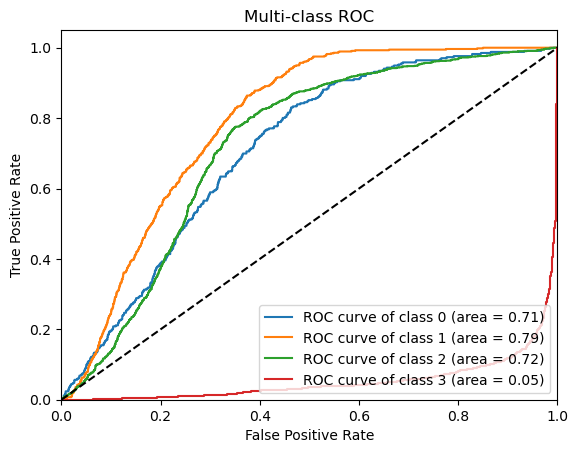

In [91]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC curve
y_bin = label_binarize(true_priorities, classes=np.unique(true_priorities))
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], test_priority_logits[:, i].cpu().numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


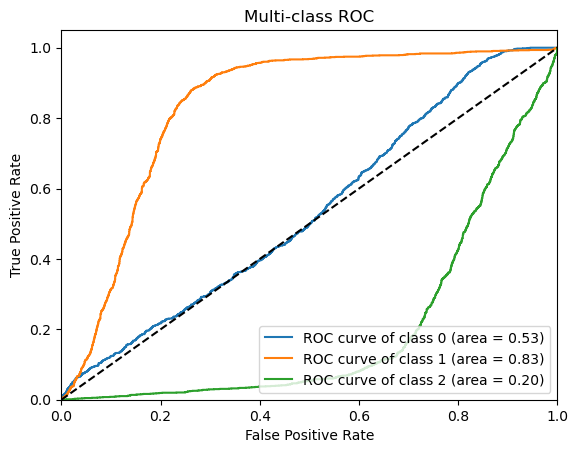

In [92]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC curve
y_bin = label_binarize(adjusted_severities, classes=np.unique(adjusted_severities))
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], test_priority_logits[:, i].cpu().numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


In [93]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_curve(y_true, y_score, n_classes):
    # Binarize the output
    y_true = label_binarize(y_true, classes=np.arange(n_classes))
    y_score = label_binarize(y_score, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure(figsize=(7, 7))
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()


In [94]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_curve(y_true, y_score, n_classes):
    # Binarize the output
    y_true = label_binarize(y_true, classes=np.arange(n_classes))
    y_score = label_binarize(y_score, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure(figsize=(7, 7))
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()


In [95]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


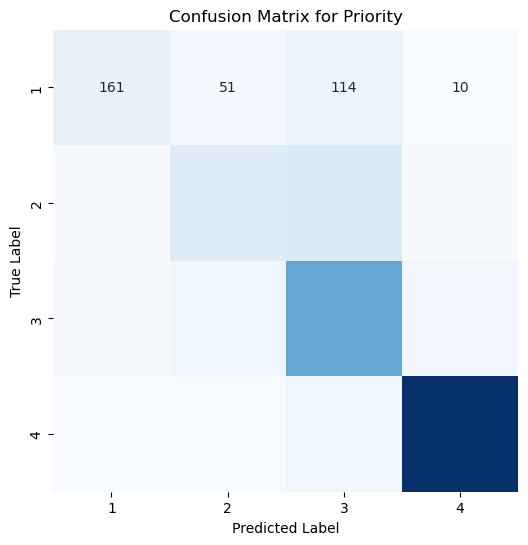

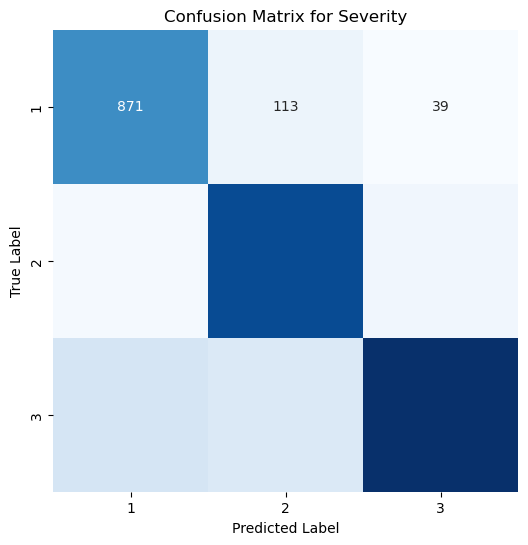

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Calculate confusion matrices for adjusted predictions
cm_priority = confusion_matrix(true_priorities, adjusted_priorities)
cm_severity = confusion_matrix(true_severities, adjusted_severities)

# Assuming the classes for priority and severity are known, e.g., [0, 1, 2, 3, 4]
priority_classes = [1, 2, 3, 4]
severity_classes = [ 1, 2, 3]

# Plotting the confusion matrices
plot_confusion_matrix(cm_priority, priority_classes, title='Confusion Matrix for Priority')
plot_confusion_matrix(cm_severity, severity_classes, title='Confusion Matrix for Severity')


In [97]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # Assuming binary classification for demonstration. You need to adapt this for multi-class.
# # Compute ROC curve and ROC area for each class
# fpr, tpr, _ = roc_curve(true_priorities, test_priority_logits[:, 1].cpu().numpy())  # Adapt for your case
# roc_auc = auc(fpr, tpr)

# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()


In [98]:
import numpy as np


# Assuming you have numpy arrays for predicted priorities and severities


# Count of each element in true priorities
unique_priorities, counts_priorities = np.unique(true_priorities, return_counts=True)
true_priority_counts = dict(zip(unique_priorities, counts_priorities))

# Count of each element in true severities
unique_severities, counts_severities = np.unique(true_severities, return_counts=True)
true_severity_counts = dict(zip(unique_severities, counts_severities))

# Print the counts for true priorities
print("True Priority Counts:")
for priority, count in true_priority_counts.items():
    print(f"Priority {priority}: {count} occurrences")

# Print the counts for true severities
print("\nTrue Severity Counts:")
for severity, count in true_severity_counts.items():
    print(f"Severity {severity}: {count} occurrences")
# Count of each element in predicted priorities
unique_priorities, counts_priorities = np.unique(predicted_priorities, return_counts=True)
predicted_priority_counts = dict(zip(unique_priorities, counts_priorities))

# Count of each element in predicted severities
unique_severities, counts_severities = np.unique(predicted_severities, return_counts=True)
predicted_severity_counts = dict(zip(unique_severities, counts_severities))

# Print the counts for predicted priorities
print("Predicted Priority Counts:")
for priority, count in predicted_priority_counts.items():
    print(f"Priority {priority}: {count} occurrences")

# Print the counts for predicted severities
print("\nPredicted Severity Counts:")
for severity, count in predicted_severity_counts.items():
    print(f"Severity {severity}: {count} occurrences")


True Priority Counts:
Priority 1: 336 occurrences
Priority 2: 559 occurrences
Priority 3: 1226 occurrences
Priority 4: 2070 occurrences

True Severity Counts:
Severity 1: 1023 occurrences
Severity 2: 1349 occurrences
Severity 3: 1819 occurrences
Predicted Priority Counts:
Priority 1: 169 occurrences
Priority 2: 337 occurrences
Priority 3: 1610 occurrences
Priority 4: 2075 occurrences

Predicted Severity Counts:
Severity 1: 900 occurrences
Severity 2: 1717 occurrences
Severity 3: 1574 occurrences


In [99]:
# # Assuming you have imported necessary libraries and prepared your data

# # Compute class weights for the 4 classes in priority
# priority_classes = np.unique(firefox_issues_df['priority'])  # Make sure this contains 4 unique class labels
# priority_weights = compute_class_weight(class_weight='balanced', classes=priority_classes, y=firefox_issues_df['priority'])
# priority_weights_tensor = torch.tensor(priority_weights, dtype=torch.float).to(device)

# # Initialize your model with the correct number of output features for priority
# model = HybridGNN(num_node_features=773, num_classes_priority=4, num_classes_severity=1, num_units=128)  # Assuming severity task is not relevant here
# model.to(device)

# # Initialize the loss function with the computed class weights
# criterion_priority = CrossEntropyLoss(weight=priority_weights_tensor)


In [100]:
# import torch
# import torch.nn.functional as F
# from torch_geometric.nn import SAGEConv, GATConv

# class HybridGNN(torch.nn.Module):
#     def __init__(self, num_node_features, num_classes_priority, num_classes_severity, num_units):
#         super(HybridGNN, self).__init__()

#         # First layer is a GraphSAGE layer
#         self.conv1 = SAGEConv(num_node_features, num_units)

#         # Second layer is a GAT layer with multi-head attention
#         self.conv2 = GATConv(num_units, num_units // 2, heads=2, concat=True)

#         # Final output features adjusted for concatenated multi-head attention
#         final_out_features = num_units  # Assuming concat=True doubles the feature size

#         # Update the number of output features for priority to 4
#         self.out_priority = torch.nn.Linear(final_out_features, 4)  # Updated for 4 priority classes

#         # Keep or update the output layer for severity based on your requirements
#         self.out_severity = torch.nn.Linear(final_out_features, num_classes_severity)

#     def forward(self, x, edge_index):
#         # GraphSAGE convolution
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)

#         # GAT convolution
#         x = self.conv2(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, training=self.training)

#         # Output layers for 'priority' and 'severity'
#         priority = self.out_priority(x)
#         severity = self.out_severity(x)

#         return F.log_softmax(priority, dim=1), F.log_softmax(severity, dim=1)


In [101]:
# model = HybridGNN(num_node_features=773, num_classes_priority=4, num_classes_severity=3, num_units=128)
# model.to(device)  # Make sure to move your model to the appropriate device


In [102]:
from sklearn.utils.class_weight import compute_class_weight

priority_classes = np.unique(firefox_issues_df['priority'])  # Assuming this is a numpy array of your priority labels
priority_weights = compute_class_weight('balanced', classes=priority_classes, y=firefox_issues_df['priority'])
priority_weights_tensor = torch.tensor(priority_weights, dtype=torch.float).to(device)


In [103]:
criterion_priority = torch.nn.CrossEntropyLoss(weight=priority_weights_tensor)


In [104]:
# Set the device to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

HybridGNN(
  (conv1): SAGEConv(773, 128, aggr=mean)
  (conv2): GATConv(128, 64, heads=2)
  (out_priority): Linear(in_features=128, out_features=7, bias=True)
  (out_severity): Linear(in_features=128, out_features=6, bias=True)
)

In [105]:
# # Assuming 'data.y_priority' and 'data.y_severity' are your label tensors

# # Count unique classes in priority and severity labels
# unique_priority_classes = data.y_priority.unique().numel()
# unique_severity_classes = data.y_severity.unique().numel()

# print(f"Unique Priority Classes: {unique_priority_classes}")
# print(f"Unique Severity Classes: {unique_severity_classes}")

# # Assuming 'priority_weights' and 'severity_weights' are your weight tensors
# # Verify dimensions of the weight tensors
# priority_weight_dim = priority_weights.shape[0]  # Number of elements in priority_weights tensor
# severity_weight_dim = severity_weights.shape[0]  # Number of elements in severity_weights tensor

# # Check if dimensions match
# priority_check = unique_priority_classes == priority_weight_dim
# severity_check = unique_severity_classes == severity_weight_dim

# print(f"Priority weights dimension check: {'Match' if priority_check else 'Mismatch'}")
# print(f"Severity weights dimension check: {'Match' if severity_check else 'Mismatch'}")

# if not priority_check:
#     print(f"Expected priority weight dimension: {unique_priority_classes}, but got: {priority_weight_dim}")

# if not severity_check:
#     print(f"Expected severity weight dimension: {unique_severity_classes}, but got: {severity_weight_dim}")


In [106]:
# def calculate_class_weights(labels):
#     # Count the occurrence of each class
#     class_counts = torch.bincount(labels)
#     # Calculate weights: The number of samples divided by (number of classes * number of samples for each class)
#     class_weights = len(labels) / (class_counts.size(0) * class_counts.float())
#     return class_weights

# # Recalculate the weights for priority and severity
# priority_weights = calculate_class_weights(data.y_priority)
# severity_weights = calculate_class_weights(data.y_severity)

# # Adjust the weights to have the correct dimensions by slicing if necessary
# priority_weights = priority_weights[:unique_priority_classes]
# severity_weights = severity_weights[:unique_severity_classes]

# # Print the adjusted weights to verify
# print(f"Adjusted Priority Weights: {priority_weights}")
# print(f"Adjusted Severity Weights: {severity_weights}")

# # Move the adjusted weights to the correct device (CPU or GPU)
# priority_weights = priority_weights.to(device)
# severity_weights = severity_weights.to(device)

# # Define the loss functions with the adjusted weights
# criterion_priority = torch.nn.CrossEntropyLoss(weight=priority_weights)
# criterion_severity = torch.nn.CrossEntropyLoss(weight=severity_weights)


In [107]:
# # Adjust labels to be zero-indexed if they are not already
# data.y_priority = data.y_priority - data.y_priority.min()
# data.y_severity = data.y_severity - data.y_severity.min()

# def calculate_class_weights(labels, num_classes):
#     class_counts = torch.zeros(num_classes, device=labels.device)
#     for label in labels:
#         class_counts[label] += 1
#     # Add a small constant to avoid division by zero
#     class_weights = 1.0 / (class_counts + 0.01)
#     return class_weights

# # Recalculate the class weights with adjusted labels
# num_classes_priority = data.y_priority.max().item() + 1  # Ensure this matches the actual number of classes
# num_classes_severity = data.y_severity.max().item() + 1  # Ensure this matches the actual number of classes

# priority_weights = calculate_class_weights(data.y_priority, num_classes_priority)
# severity_weights = calculate_class_weights(data.y_severity, num_classes_severity)

# print(f"Adjusted Priority Weights: {priority_weights}")
# print(f"Adjusted Severity Weights: {severity_weights}")

# # Move the adjusted weights to the correct device (CPU or GPU)
# priority_weights = priority_weights.to(device)
# severity_weights = severity_weights.to(device)

# # Define the loss functions with the adjusted weights
# criterion_priority = torch.nn.CrossEntropyLoss(weight=priority_weights)
# criterion_severity = torch.nn.CrossEntropyLoss(weight=severity_weights)


In [108]:
# # Ensure model is on the correct device
# model = model.to(device)

# Move tensors to the same device as the model
data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)
data.y_priority = data.y_priority.to(device)
data.y_severity = data.y_severity.to(device)
data.train_mask = data.train_mask.to(device)

# # Now, your forward pass should work without device mismatch issues
# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()

#     # Forward pass (now all tensors involved are on the correct device)
#     priority_logits, severity_logits = model(data.x, data.edge_index)

#     # Apply the mask and compute loss as before
#     masked_priority_logits = priority_logits[data.train_mask]
#     masked_severity_logits = severity_logits[data.train_mask]
#     masked_y_priority = data.y_priority[data.train_mask]
#     masked_y_severity = data.y_severity[data.train_mask]

#     loss_priority = criterion_priority(masked_priority_logits, masked_y_priority)
#     loss_severity = criterion_severity(masked_severity_logits, masked_y_severity)

#     # Combine and backpropagate losses
#     loss = loss_priority + loss_severity
#     loss.backward()
#     optimizer.step()

#     if epoch % log_interval == 0:
#         print(f'Epoch: {epoch}/{num_epochs}, Total Loss: {loss.item():.4f}, '
#               f'Priority Loss: {loss_priority.item():.4f}, Severity Loss: {loss_severity.item():.4f}')


In [109]:
# import itertools
# import torch.optim as optim

# # Define hyperparameter space: Learning rates, batch sizes, etc.
# learning_rates = [0.001, 0.01, 0.1]
# num_units_options = [64, 128, 256]  # Number of units in GNN layers
# dropouts = [0.1, 0.5]  # Dropout rates

# # Function to create and return the model
# def create_model(num_node_features, num_classes_priority, num_classes_severity, num_units, dropout_rate):
#     model = HybridGNN(num_node_features=num_node_features, num_classes_priority=num_classes_priority, 
#                       num_classes_severity=num_classes_severity, num_units=num_units)
#     return model

# # Function to perform a single training epoch
# def train(model, data, optimizer, criterion_priority, criterion_severity):
#     model.train()
#     optimizer.zero_grad()
#     priority_logits, severity_logits = model(data.x, data.edge_index)
#     loss_priority = criterion_priority(priority_logits[data.train_mask], data.y_priority[data.train_mask])
#     loss_severity = criterion_severity(severity_logits[data.train_mask], data.y_severity[data.train_mask])
#     loss = loss_priority + loss_severity
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# # Hyperparameter tuning loop
# best_loss = float('inf')
# best_params = {}

# for lr, num_units, dropout in itertools.product(learning_rates, num_units_options, dropouts):
#     # Create model with current set of hyperparameters
#     model = create_model(num_node_features=773, num_classes_priority=4, num_classes_severity=3, 
#                          num_units=num_units, dropout_rate=dropout).to(device)

#     # Initialize optimizer with current learning rate
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     # Run a single training epoch to get a sense of how good these hyperparameters are
#     epoch_loss = train(model, data, optimizer, criterion_priority, criterion_severity)

#     print(f"LR: {lr}, Units: {num_units}, Dropout: {dropout}, Loss: {epoch_loss}")

#     # Update best parameters if current loss is lower
#     if epoch_loss < best_loss:
#         best_loss = epoch_loss
#         best_params = {'lr': lr, 'num_units': num_units, 'dropout': dropout}

# print(f"Best parameters: {best_params}, Best loss: {best_loss}")


In [110]:
# import torch
# num_epochs = 5000
# # Function to calculate weights for each class
# def calculate_class_weights(labels):
#     class_counts = labels.bincount()
#     class_weights = 1. / class_counts.float()
#     class_weights[class_counts == 0] = 0  # Handle classes with zero samples if any
#     return class_weights

# # Calculate weights for priority and severity classes
# priority_weights = calculate_class_weights(data.y_priority)
# severity_weights = calculate_class_weights(data.y_severity)

# # Move weights to the same device as your model and data
# priority_weights = priority_weights.to(device)
# severity_weights = severity_weights.to(device)

# # Define weighted loss functions
# criterion_priority = torch.nn.CrossEntropyLoss(weight=priority_weights)
# criterion_severity = torch.nn.CrossEntropyLoss(weight=severity_weights)

# # Training loop remains mostly the same
# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()

#     # Forward pass
#     priority_logits, severity_logits = model(data.x, data.edge_index)

#     # Apply the mask and compute loss as before
#     masked_priority_logits = priority_logits[data.train_mask]
#     masked_severity_logits = severity_logits[data.train_mask]
#     masked_y_priority = data.y_priority[data.train_mask.nonzero(as_tuple=True)[0]]
#     masked_y_severity = data.y_severity[data.train_mask.nonzero(as_tuple=True)[0]]

#     loss_priority = criterion_priority(masked_priority_logits, masked_y_priority)
#     loss_severity = criterion_severity(masked_severity_logits, masked_y_severity)

#     # Combine and backpropagate losses
#     loss = loss_priority + loss_severity  # Consider weighting these losses if needed
#     loss.backward()
#     optimizer.step()

#     if epoch % log_interval == 0:
#         print(f'Epoch: {epoch}/{num_epochs}, Total Loss: {loss.item():.4f}, '
#               f'Priority Loss: {loss_priority.item():.4f}, Severity Loss: {loss_severity.item():.4f}')


In [111]:
# # Recreate the model with the best hyperparameters
# model = HybridGNN(num_node_features=773,  # Adjust this based on your input feature size
#                   num_classes_priority=4, 
#                   num_classes_severity=3, 
#                   num_units=64)  # Using the best number of units
# model = model.to(device)

# # Redefine the optimizer with the best learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Proceed with the training loop
# num_epochs = 300  # You can adjust this based on your needs
# log_interval = 10  # How often to log the training information

# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()

#     # Forward pass
#     priority_logits, severity_logits = model(data.x, data.edge_index)

#     # Apply the mask and compute the loss
#     masked_priority_logits = priority_logits[data.train_mask]
#     masked_severity_logits = severity_logits[data.train_mask]
#     masked_y_priority = data.y_priority[data.train_mask.nonzero(as_tuple=True)[0]]
#     masked_y_severity = data.y_severity[data.train_mask.nonzero(as_tuple=True)[0]]

#     # Compute the loss with class weights
#     loss_priority = criterion_priority(masked_priority_logits, masked_y_priority)
#     loss_severity = criterion_severity(masked_severity_logits, masked_y_severity)

#     # Combine the losses and backpropagate
#     loss = loss_priority + loss_severity
#     loss.backward()
#     optimizer.step()

#     # Log training information
#     if epoch % log_interval == 0:
#         print(f'Epoch: {epoch}/{num_epochs}, Total Loss: {loss.item():.4f}, '
#               f'Priority Loss: {loss_priority.item():.4f}, Severity Loss: {loss_severity.item():.4f}')


In [112]:
# def test(model, data):
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():  # No need to track gradients
#         # Forward pass
#         priority_logits, severity_logits = model(data.x, data.edge_index)
        
#         # Convert logits to predicted classes
#         _, priority_pred = priority_logits.max(dim=1)  # Use argmax to get the predicted class
#         _, severity_pred = severity_logits.max(dim=1)  # Use argmax to get the predicted class

#         # Mask to select only the test nodes
#         test_priority_pred = priority_pred[data.test_mask]
#         test_severity_pred = severity_pred[data.test_mask]
#         test_priority_labels = data.y_priority[data.test_mask]
#         test_severity_labels = data.y_severity[data.test_mask]

#         # Calculate accuracy for priority and severity
#         priority_correct = test_priority_pred.eq(test_priority_labels).sum().item()
#         severity_correct = test_severity_pred.eq(test_severity_labels).sum().item()
#         priority_acc = priority_correct / test_priority_labels.size(0)
#         severity_acc = severity_correct / test_severity_labels.size(0)

#     return priority_acc, severity_acc

# # Test the model
# priority_accuracy, severity_accuracy = test(model, data)

# print(f"Priority Classification Accuracy: {priority_accuracy * 100:.2f}%")
# print(f"Severity Classification Accuracy: {severity_accuracy * 100:.2f}%")


Transfer Learning 

In [113]:
# Save the entire model
torch.save(model, 'core_defect_model_file.pth')

# Load the entire model
# model = torch.load('path_to_save/my_model.pth')
model.eval()  # Don't forget to call eval() for inference!


HybridGNN(
  (conv1): SAGEConv(773, 128, aggr=mean)
  (conv2): GATConv(128, 64, heads=2)
  (out_priority): Linear(in_features=128, out_features=7, bias=True)
  (out_severity): Linear(in_features=128, out_features=6, bias=True)
)

In [114]:
# Save only the model parameters (recommended)
# torch.save(model.state_dict(), 'core_defect_model_file.pth')

# Load the model parameters (assuming you have the model class defined)
model = HybridGNN(num_node_features=773, num_classes_priority=4, num_classes_severity=3, num_units=128)  # Re-create the model structure
model= (torch.load('core_defect_model_file.pth'))
model.eval()  # Switch to evaluation mode


HybridGNN(
  (conv1): SAGEConv(773, 128, aggr=mean)
  (conv2): GATConv(128, 64, heads=2)
  (out_priority): Linear(in_features=128, out_features=7, bias=True)
  (out_severity): Linear(in_features=128, out_features=6, bias=True)
)

In [115]:
import pandas as pd
import re
import torch
from torch_geometric.data import Data
from transformers import BertTokenizer, BertModel
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader

# Load the dataset
file_path = "firefox_defect_updated.csv"
firefox_issues_df = pd.read_csv(file_path)

# Clean and preprocess data
firefox_issues_df.dropna(subset=['severity', 'product', 'component', 'priority', 'status'], inplace=True)
firefox_issues_df['summary'] = firefox_issues_df['summary'].str.lower()
firefox_issues_df['summary'] = firefox_issues_df['summary'].apply(lambda x: re.sub(r'[^a-z0-9\s]', '', x))

firefox_issues_df.replace('--', pd.NA, inplace=True)
firefox_issues_df.dropna(subset=['severity', 'priority'], inplace=True)

# Encode 'Product', 'Component', and 'Status' using label encoding
product_encoder = LabelEncoder()
component_encoder = LabelEncoder()
status_encoder = LabelEncoder()
firefox_issues_df['product_encoded'] = product_encoder.fit_transform(firefox_issues_df['product'])
firefox_issues_df['component_encoded'] = component_encoder.fit_transform(firefox_issues_df['component'])
firefox_issues_df['status_encoded'] = status_encoder.fit_transform(firefox_issues_df['status'])

# Initialize BERT tokenizer and model with a specified cache directory
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='cache')
model = BertModel.from_pretrained('bert-base-uncased', cache_dir='cache')

# Set the device to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function for batch processing of summaries to obtain BERT embeddings
def batch_encode_summaries(summaries, tokenizer, model, batch_size=16):
    dataloader = DataLoader(summaries, batch_size=batch_size, shuffle=False)
    text_features_list = []

    for batch_summaries in dataloader:
        inputs = tokenizer(batch_summaries, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_text_features = outputs.last_hidden_state.mean(dim=1)
        text_features_list.append(batch_text_features.cpu())  # Move to CPU to avoid GPU memory overload

    return torch.cat(text_features_list, dim=0)

# Encode summaries in batches to get text features
text_features = batch_encode_summaries(firefox_issues_df['summary'].tolist(), tokenizer, model, batch_size=16)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns for scaling
features_to_scale = firefox_issues_df[['product_encoded', 'component_encoded', 'status_encoded']]

# Fit the scaler to the features and transform them to a 0-1 range
scaled_features = scaler.fit_transform(features_to_scale)

# Update the dataframe with the scaled features
firefox_issues_df[['product_encoded', 'component_encoded', 'status_encoded']] = scaled_features

# Calculate 'count of blocks' and 'count of depends_on'
firefox_issues_df['blocks_count'] = firefox_issues_df['blocks'].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)
firefox_issues_df['depends_on_count'] = firefox_issues_df['depends_on'].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)

# Scale the counts
count_features = firefox_issues_df[['blocks_count', 'depends_on_count']]
scaled_count_features = scaler.fit_transform(count_features)
firefox_issues_df[['blocks_count', 'depends_on_count']] = scaled_count_features

# Prepare the features tensor including the new count features
features_tensor = torch.tensor(firefox_issues_df[['product_encoded', 'component_encoded', 'status_encoded', 'blocks_count', 'depends_on_count']].values, dtype=torch.float)

# Concatenate the BERT embeddings with the scaled features
features = torch.cat((text_features, features_tensor), dim=1)

# Prepare edge index and map issue IDs to node indices
node_id_mapping = {node_id: idx for idx, node_id in enumerate(firefox_issues_df['id'])}
edge_index = []

for _, row in firefox_issues_df.iterrows():
    node_idx = node_id_mapping[row['id']]
    blocked_ids = ast.literal_eval(row['blocks']) if pd.notnull(row['blocks']) else []
    depends_ids = ast.literal_eval(row['depends_on']) if pd.notnull(row['depends_on']) else []

    for blocked_id in blocked_ids:
        if blocked_id in node_id_mapping:
            edge_index.append([node_idx, node_id_mapping[blocked_id]])

    for depend_id in depends_ids:
        if depend_id in node_id_mapping:
            edge_index.append([ node_idx,node_id_mapping[depend_id]])

edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Convert the 'priority' and 'severity' columns to tensors
priority_labels = torch.tensor(firefox_issues_df['priority'].values, dtype=torch.long)
severity_labels = torch.tensor(firefox_issues_df['severity'].values, dtype=torch.long)

# Create PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_index_tensor, y_priority=priority_labels, y_severity=severity_labels)

# Save the Data object
data_save_path = 'firefox_issues_data.pt'
torch.save(data, data_save_path)


In [116]:
# Load the pre-trained model's state dict
pretrained_model = HybridGNN(num_node_features=773, num_classes_priority=4, num_classes_severity=3, num_units=128)
pretrained_model= (torch.load('core_defect_model_file.pth'))


In [117]:
# import torch
# import torch.nn.functional as F
# from torch_geometric.nn import SAGEConv, GATConv

# class TransferHybridGNN(torch.nn.Module):
#     def __init__(self, pretrained_model, num_classes_priority_new, num_classes_severity_new):
#         super(TransferHybridGNN, self).__init__()
        
#         # Use the pre-trained convolutional layers from the existing model
#         self.conv1 = pretrained_model.conv1
#         self.conv2 = pretrained_model.conv2

#         # Freeze the pre-trained layers
#         for param in self.conv1.parameters():
#             param.requires_grad = False
#         for param in self.conv2.parameters():
#             param.requires_grad = False

#         # Replace the final layers with new ones for the new task
#         final_out_features = pretrained_model.out_priority.in_features  # Get the size of input features for the final layers from the pre-trained model
#         self.out_priority = torch.nn.Linear(final_out_features, num_classes_priority_new)
#         self.out_severity = torch.nn.Linear(final_out_features, num_classes_severity_new)

#     def forward(self, x, edge_index):
#         # Use the pre-trained convolutions
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)

#         x = self.conv2(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, training=self.training)

#         # New final layers for 'priority' and 'severity'
#         priority = self.out_priority(x)
#         severity = self.out_severity(x)

#         return F.log_softmax(priority, dim=1), F.log_softmax(severity, dim=1)

# # Load the pre-trained model
# # pretrained_model = ... # Load your pre-trained model here

# # Create a new model for transfer learning
# # Adjust num_classes_priority_new and num_classes_severity_new based on your new dataset
# transfer_model = TransferHybridGNN(pretrained_model, num_classes_priority_new=4, num_classes_severity_new=3)

# # Now, you can define a new optimizer that only updates the parameters of the final layers
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=0.001)

# # Continue with the training loop on your new dataset as before


In [118]:
# import torch.optim as optim
# # Assuming TransferHybridGNN is your new class adapted for transfer learning
# transfer_model = TransferHybridGNN(pretrained_model, 4, 3)
# import torch.optim as optim

# # Create an optimizer for the transfer_model instance
# optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)  # Adjust learning rate as needed


In [119]:
# criterion = torch.nn.CrossEntropyLoss() 

In [120]:
from torch.utils.data import DataLoader

# Assuming 'new_dataset' is your new dataset prepared for PyTorch
new_data_loader = DataLoader(data, batch_size=100, shuffle=True)


In [121]:
# Check the range of your labels
print("Severity label range:", data.y_severity.min().item(), "to", data.y_severity.max().item())

# If necessary, adjust your labels to ensure they start at 0
if data.y_severity.min().item() < 0 or data.y_severity.max().item() >= num_classes_severity:
    # Adjust labels here, for example by subtracting 1 from all labels if they start at 1
    data.y_severity = data.y_severity - data.y_severity.min().item()

# Verify adjustment
print("Adjusted severity label range:", data.y_severity.min().item(), "to", data.y_severity.max().item())


Severity label range: 1 to 4
Adjusted severity label range: 0 to 3


In [122]:
import torch
import pandas as pd
import numpy as np
import re
import ast
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from transformers import BertTokenizer, BertModel
from torch_geometric.data import Data
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Set the device to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [123]:
model = HybridGNN(num_node_features=773, num_classes_priority=4, num_classes_severity=3, num_units=128)
model = torch.load('core_defect_model_file.pth', map_location=device)
model.to(device)
model.eval()  # Set the model to evaluation mode

HybridGNN(
  (conv1): SAGEConv(773, 128, aggr=mean)
  (conv2): GATConv(128, 64, heads=2)
  (out_priority): Linear(in_features=128, out_features=7, bias=True)
  (out_severity): Linear(in_features=128, out_features=6, bias=True)
)

In [124]:
data.to(device) 

Data(x=[7722, 773], edge_index=[2, 972], y_priority=[7722], y_severity=[7722])

In [125]:
new_data = data 
new_data.to(device) 

Data(x=[7722, 773], edge_index=[2, 972], y_priority=[7722], y_severity=[7722])

In [126]:
import torch

def split_data(data):
    # Calculate the total number of nodes
    num_nodes = data.x.size(0)

    # Define the split sizes
    train_size = 0.70  # 70% of the data for training
    val_size = 0.15  # 15% of the data for validation
    test_size = 0.15  # 15% of the data for testing

    # Generate shuffled indices
    indices = torch.randperm(num_nodes)

    # Calculate the number of nodes for each split
    num_train_nodes = int(train_size * num_nodes)
    num_val_nodes = int(val_size * num_nodes)

    # Split the indices for each set
    train_indices = indices[:num_train_nodes]
    val_indices = indices[num_train_nodes:num_train_nodes + num_val_nodes]
    test_indices = indices[num_train_nodes + num_val_nodes:]

    # Create boolean masks
    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    data.train_mask[train_indices] = True
    data.val_mask[val_indices] = True
    data.test_mask[test_indices] = True

    # Calculate the number of nodes in each set
    num_nodes_train = data.train_mask.sum().item()
    num_nodes_val = data.val_mask.sum().item()
    num_nodes_test = data.test_mask.sum().item()

    print(f"Number of nodes in the training set: {num_nodes_train}")
    print(f"Number of nodes in the validation set: {num_nodes_val}")
    print(f"Number of nodes in the test set: {num_nodes_test}")

    return data

# Assuming 'new_data' is your new PyTorch Geometric Data object
new_data = split_data(new_data)


Number of nodes in the training set: 5405
Number of nodes in the validation set: 1158
Number of nodes in the test set: 1159


In [129]:
# Assuming 'new_data.test_mask' is the mask for test data
test_mask = new_data.test_mask

# Apply the test mask to the true labels
true_priorities = new_data.y_priority[test_mask]
true_severities = new_data.y_severity[test_mask]

# Ensure the model is in evaluation mode
model.eval()

with torch.no_grad():
    # Forward pass using the entire graph
    priority_logits, severity_logits = model(new_data.x.to(device), new_data.edge_index.to(device))

    # Apply the test mask to the logits
    test_priority_logits = priority_logits[test_mask]
    test_severity_logits = severity_logits[test_mask]

    # Convert logits to predicted classes
    _, predicted_priorities = torch.max(test_priority_logits, 1)
    _, predicted_severities = torch.max(test_severity_logits, 1)

# Move predictions and true labels to CPU for evaluation
predicted_priorities = predicted_priorities.cpu()
predicted_severities = predicted_severities.cpu()
true_priorities = true_priorities.cpu()
true_severities = true_severities.cpu()

# Now, calculate the accuracy or other metrics
accuracy_priority = accuracy_score(true_priorities.numpy(), predicted_priorities.numpy())
accuracy_severity = accuracy_score(true_severities.numpy(), predicted_severities.numpy())

print(f'Priority Accuracy: {accuracy_priority}')
print(f'Severity Accuracy: {accuracy_severity}')


Priority Accuracy: 0.28731665228645387
Severity Accuracy: 0.5849870578084556


In [128]:
# for epoch in range(num_epochs):
#     transfer_model.train()  # Set the model to training mode
#     optimizer.zero_grad()
`
#     # Forward pass
#     priority_logits, severity_logits = transfer_model(data.x.to(device), data.edge_index.to(device))

#     # Compute loss for each task
#     loss_priority = criterion_priority(priority_logits, data.y_priority.to(device))
#     loss_severity = criterion_severity(severity_logits, data.y_severity.to(device))  # Labels are now correctly adjusted

#     # Combine losses and perform backpropagation
#     loss = loss_priority + loss_severity
#     loss.backward()
#     optimizer.step()

#     # Add any validation or logging as needed
#     if epoch % 10 == 0:  # Example: log every 10 epochs
#         print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}')
#         # Validation logic goes here


SyntaxError: invalid syntax (2360571475.py, line 4)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# transfer_model = transfer_model.to(device)
# x = data.x.to(device)  # Move feature tensor to the correct device
# edge_index = data.edge_index.to(device)  # Move edge index tensor to the correct device

# priority_logits, severity_logits = transfer_model(x, edge_index)

# y_priority = data.y_priority.to(device)  # Move priority labels to the correct device
# y_severity = data.y_severity.to(device)  # Move severity labels to the correct device

# loss_priority = criterion_priority(priority_logits, y_priority)
# loss_severity = criterion_severity(severity_logits, y_severity)


In [ ]:
# # Load the processed Data object
# data = torch.load('firefox_issues_data.pt')
# transfer_model = transfer_model.to(device)


# num_epochs = 100  # Example number of epochs

# for epoch in range(num_epochs):
#     transfer_model.train()  # Set the model to training mode
#     optimizer.zero_grad()

#     # Assuming your model's forward method can handle the whole graph
#     priority_logits, severity_logits = transfer_model(data.x.to(device), data.edge_index.to(device))

#     # Compute loss, for example:
#     loss_priority = criterion_priority(priority_logits, data.y_priority.to(device))
#     loss_severity = criterion_severity(severity_logits, data.y_severity.to(device))
#     loss = loss_priority + loss_severity  # Combine losses, potentially with different weights

#     loss.backward()  # Backpropagate the error
#     optimizer.step()  # Update model parameters

#     # Add any validation or logging as needed
